# Custom Newton solvers
Author: Jørgen S. Dokken

Newtons method, as used in the [non-linear Poisson](./../chapter2/nonlinpoisson_code) problem, is a way of solving a non-linear equation as a sequence of linear equations.

Given a function $F:\mathbb{R}^M\mapsto \mathbb{R}^M$, we have that $u_k, u_{k+1}\in \mathbb{R}^M$ is related as:

$$x_{k+1} = x_{k} - J_F(x_k)^{-1} F(x_k)$$

where $J_F$ is the Jacobian matrix of $F$.

We can rewrite this equation as $\delta x_k = x_{k+1} - x_{k}$,

$$
J_F(x_k)\delta x_k = - F(x_k)
$$

and

$$
x_{k+1} = x_k + \delta x_k.
$$

## Problem specification
We start by importing all packages needed to solve the problem.

In [1]:
import dolfinx
import matplotlib.pyplot as plt
import numpy as np
import pyvista
import ufl
from mpi4py import MPI
from petsc4py import PETSc

We will consider the following non-linear problem:

$$ u^2 - 2 u = x^2 + 4x + 3 \text{ in } [0,1] $$
For this problem, we have two solutions, $u=-x-1$, $u=x+3$.
We define these roots as python functions, and create an appropriate spacing for plotting these soultions.

In [2]:
def root_0(x):
    return 3 + x[0]


def root_1(x):
    return -1 - x[0]


N = 10
roots = [root_0, root_1]
x_spacing = np.linspace(0, 1, N)

We will start with an initial guess for this problem, $u_0 = 0$.
Next, we define the mesh, and the appropriate function space and function `uh` to hold the approximate solution.

In [3]:
mesh = dolfinx.mesh.create_unit_interval(MPI.COMM_WORLD, N)
V = dolfinx.fem.FunctionSpace(mesh, ("Lagrange", 1))
uh = dolfinx.fem.Function(V)

## Definition of residual and Jacobian
Next, we define the variational form, by multiplying by a test function and integrating over the domain $[0,1]$

In [4]:
v = ufl.TestFunction(V)
x = ufl.SpatialCoordinate(mesh)
F = uh**2 * v * ufl.dx - 2 * uh * v * ufl.dx - (x[0]**2 + 4 * x[0] + 3) * v * ufl.dx
residual = dolfinx.fem.form(F)

Next, we can define the jacobian $J_F$, by using `ufl.derivative`.

In [5]:
J = ufl.derivative(F, uh)
jacobian = dolfinx.fem.form(J)

As we will solve this problem in an iterative fashion, we would like to create the sparse matrix and vector containing the residual only once.
## Setup of iteration-independent structures

In [6]:
A = dolfinx.fem.petsc.create_matrix(jacobian)
L = dolfinx.fem.petsc.create_vector(residual)

Next, we create the linear solver and the vector to hold `dx`.

In [7]:
solver = PETSc.KSP().create(mesh.comm)
solver.setOperators(A)
dx = dolfinx.fem.Function(V)

We would like to monitor the evolution of `uh` for each iteration. Therefore, we get the dof coordinates, and sort them in increasing order.

In [8]:
i = 0
coords = V.tabulate_dof_coordinates()[:, 0]
sort_order = np.argsort(coords)
max_iterations = 25
solutions = np.zeros((max_iterations + 1, len(coords)))
solutions[0] = uh.x.array[sort_order]

We are now ready to solve the linear problem. At each iteration, we reassemble the Jacobian and residual, and use the norm of the magnitude of the update (`dx`) as a termination criteria.
## The Newton iterations

In [9]:
i = 0
while i < max_iterations:
    # Assemble Jacobian and residual
    with L.localForm() as loc_L:
        loc_L.set(0)
    A.zeroEntries()
    dolfinx.fem.petsc.assemble_matrix(A, jacobian)
    A.assemble()
    dolfinx.fem.petsc.assemble_vector(L, residual)
    L.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)

    # Scale residual by -1
    L.scale(-1)
    L.ghostUpdate(addv=PETSc.InsertMode.INSERT_VALUES, mode=PETSc.ScatterMode.FORWARD)

    # Solve linear problem
    solver.solve(L, dx.vector)
    dx.x.scatter_forward()
    # Update u_{i+1} = u_i + delta x_i
    uh.x.array[:] += dx.x.array
    i += 1

    # Compute norm of update
    correction_norm = dx.vector.norm(0)
    print(f"Iteration {i}: Correction norm {correction_norm}")
    if correction_norm < 1e-10:
        break
    solutions[i, :] = uh.x.array[sort_order]

Iteration 1: Correction norm 29.415833333333342
Iteration 2: Correction norm 10.776793575710077
Iteration 3: Correction norm 2.0488925318207616
Iteration 4: Correction norm 0.08991946662079764
Iteration 5: Correction norm 0.00022775697020822858
Iteration 6: Correction norm 2.211496656626386e-09
Iteration 7: Correction norm 1.7457052351197382e-15


We now compute the magnitude of the residual.

In [10]:
dolfinx.fem.petsc.assemble_vector(L, residual)
print(f"Final residual {L.norm(0)}")

Final residual 6.379796870252556e-16


## Visualization of Newton iterations
We next look at the evolution of the solutions and the error of the solution when compared to the two exact roots of the problem.

L2-error (root 0) 5.033222956847167
L2-error (root 1) 1.1102230246251564e-16


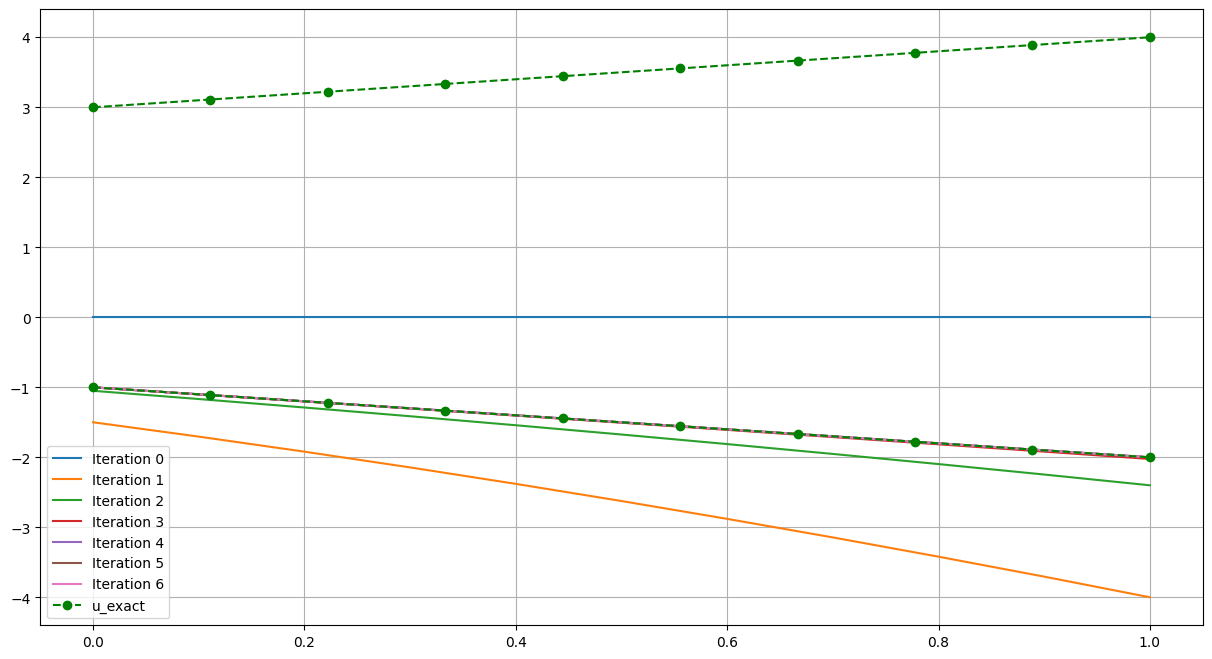

In [11]:
# Plot solution for each of the iterations
fig = plt.figure(figsize=(15, 8))
for j, solution in enumerate(solutions[:i]):
    plt.plot(coords[sort_order], solution, label=f"Iteration {j}")

# Plot each of the roots of the problem, and compare the approximate solution with each of them
args = ("--go",)
for j, root in enumerate(roots):
    u_ex = root(x)
    L2_error = dolfinx.fem.form(ufl.inner(uh - u_ex, uh - u_ex) * ufl.dx)
    global_L2 = mesh.comm.allreduce(dolfinx.fem.assemble_scalar(L2_error), op=MPI.SUM)
    print(f"L2-error (root {j}) {np.sqrt(global_L2)}")

    kwargs = {} if j == 0 else {"label": "u_exact"}
    plt.plot(x_spacing, root(x_spacing.reshape(1, -1)), *args, **kwargs)
plt.grid()
plt.legend()

# Newton's method with DirichletBC
In the previous example, we did not consider handling of Dirichlet boundary conditions.
For this example, we will consider the [non-linear Poisson](./../chapter2/nonlinpoisson)-problem.
We start by defining the mesh, the analytical solution and the forcing term $f$.

In [12]:
def q(u):
    return 1 + u**2


domain = dolfinx.mesh.create_unit_square(MPI.COMM_WORLD, 10, 10)
x = ufl.SpatialCoordinate(domain)
u_ufl = 1 + x[0] + 2 * x[1]
f = - ufl.div(q(u_ufl) * ufl.grad(u_ufl))


def u_exact(x):
    return eval(str(u_ufl))

Next, we define the boundary condition `bc`, the residual `F` and the Jacobian `J`.

In [13]:
V = dolfinx.fem.FunctionSpace(domain, ("Lagrange", 1))
u_D = dolfinx.fem.Function(V)
u_D.interpolate(u_exact)
fdim = domain.topology.dim - 1
domain.topology.create_connectivity(fdim, fdim + 1)
boundary_facets = dolfinx.mesh.exterior_facet_indices(domain.topology)
bc = dolfinx.fem.dirichletbc(u_D, dolfinx.fem.locate_dofs_topological(V, fdim, boundary_facets))

uh = dolfinx.fem.Function(V)
v = ufl.TestFunction(V)
F = q(uh) * ufl.dot(ufl.grad(uh), ufl.grad(v)) * ufl.dx - f * v * ufl.dx
J = ufl.derivative(F, uh)
residual = dolfinx.fem.form(F)
jacobian = dolfinx.fem.form(J)


Next, we define the matrix `A`, right hand side vector `L` and the correction function `dx`

In [14]:
dx = dolfinx.fem.Function(V)
A = dolfinx.fem.petsc.create_matrix(jacobian)
L = dolfinx.fem.petsc.create_vector(residual)
solver = PETSc.KSP().create(mesh.comm)
solver.setOperators(A)

As we for this problem has strong Dirichlet conditions, we need to apply lifting to the right hand side of our Newton problem.
We previously had that we wanted to solve the system:

$$
\begin{align}
J_F(x_k)\delta x_k &= - F(x_k)\\
x_{k+1} &= x_k + \delta x_k
\end{align}
$$

we want $x_{k+1}\vert_{bc}= u_D$. However, we do not know if $x_k\vert_{bc}=u_D$.
Therefore, we want to apply the following boundary condition for our correction $\delta x_k$

$$
\delta x_k\vert_{bc} = u_D-x_k\vert_{bc}
$$

We therefore arrive at the following Newton scheme

In [15]:
i = 0
error = dolfinx.fem.form(ufl.inner(uh - u_ufl, uh - u_ufl) * ufl.dx(metadata={"quadrature_degree": 4}))
L2_error = []
dx_norm = []
while i < max_iterations:
    # Assemble Jacobian and residual
    with L.localForm() as loc_L:
        loc_L.set(0)
    A.zeroEntries()
    dolfinx.fem.petsc.assemble_matrix(A, jacobian, bcs=[bc])
    A.assemble()
    dolfinx.fem.petsc.assemble_vector(L, residual)
    L.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
    L.scale(-1)

    # Compute b - J(u_D-u_(i-1))
    dolfinx.fem.petsc.apply_lifting(L, [jacobian], [[bc]], x0=[uh.vector], scale=1)
    # Set dx|_bc = u_{i-1}-u_D
    dolfinx.fem.petsc.set_bc(L, [bc], uh.vector, 1.0)
    L.ghostUpdate(addv=PETSc.InsertMode.INSERT_VALUES, mode=PETSc.ScatterMode.FORWARD)

    # Solve linear problem
    solver.solve(L, dx.vector)
    dx.x.scatter_forward()

    # Update u_{i+1} = u_i + delta x_i
    uh.x.array[:] += dx.x.array
    i += 1

    # Compute norm of update
    correction_norm = dx.vector.norm(0)

    # Compute L2 error comparing to the analytical solution
    L2_error.append(np.sqrt(mesh.comm.allreduce(dolfinx.fem.assemble_scalar(error), op=MPI.SUM)))
    dx_norm.append(correction_norm)

    print(f"Iteration {i}: Correction norm {correction_norm}, L2 error: {L2_error[-1]}")
    if correction_norm < 1e-10:
        break

Iteration 1: Correction norm 217.42584709370274, L2 error: 1.0094486886121277
Iteration 2: Correction norm 154.6084904024956, L2 error: 1.02588563725238
Iteration 3: Correction norm 49.27246829373009, L2 error: 0.35418859182768087
Iteration 4: Correction norm 16.956120024679905, L2 error: 0.0712937382503967
Iteration 5: Correction norm 3.166797879449401, L2 error: 0.0045650470120915145
Iteration 6: Correction norm 0.17136484115613163, L2 error: 2.6269980227751225e-05
Iteration 7: Correction norm 0.0008143265267735323, L2 error: 1.2302021592446042e-09
Iteration 8: Correction norm 3.734667253358911e-08, L2 error: 7.0518563018820226e-15
Iteration 9: Correction norm 5.462777547226226e-13, L2 error: 2.739351072626026e-16


We plot the $L^2$-error and the residual norm ($\delta x$) per iteration

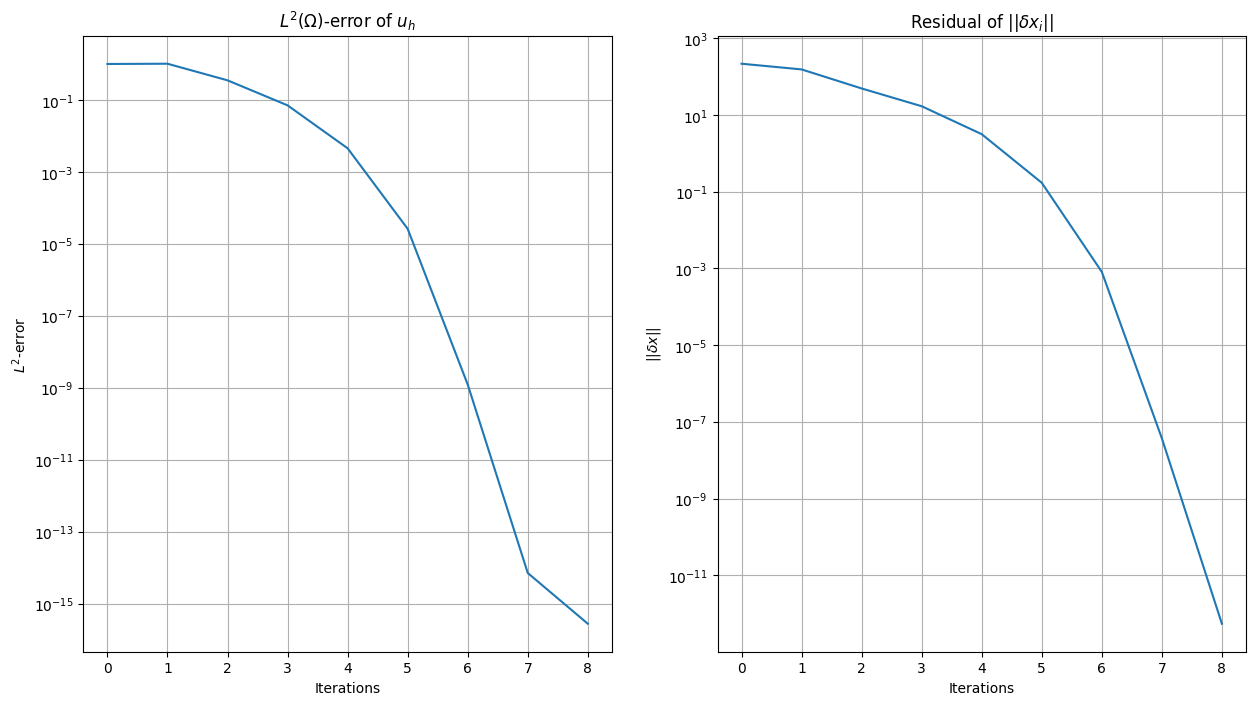

In [16]:
fig = plt.figure(figsize=(15, 8))
plt.subplot(121)
plt.plot(np.arange(i), L2_error)
plt.title(r"$L^2(\Omega)$-error of $u_h$")
ax = plt.gca()
ax.set_yscale('log')
plt.xlabel("Iterations")
plt.ylabel(r"$L^2$-error")
plt.grid()
plt.subplot(122)
plt.title(r"Residual of $\vert\vert\delta x_i\vert\vert$")
plt.plot(np.arange(i), dx_norm)
ax = plt.gca()
ax.set_yscale('log')
plt.xlabel("Iterations")
plt.ylabel(r"$\vert\vert \delta x\vert\vert$")
plt.grid()

We compute the max error and plot the solution

In [17]:
error_max = domain.comm.allreduce(np.max(np.abs(uh.x.array - u_D.x.array)), op=MPI.MAX)
if domain.comm.rank == 0:
    print(f"Error_max: {error_max:.2e}")

Error_max: 8.88e-16


In [18]:
pyvista.start_xvfb()
u_topology, u_cell_types, u_geometry = dolfinx.plot.create_vtk_mesh(V)
u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
u_grid.point_data["u"] = uh.x.array.real
u_grid.set_active_scalars("u")
u_plotter = pyvista.Plotter()
u_plotter.add_mesh(u_grid, show_edges=True)
u_plotter.view_xy()
if not pyvista.OFF_SCREEN:
    u_plotter.show()

VTKRenderWindowSynchronized(vtkXOpenGLRenderWindow, color_mappers=[LinearColorMapper(id='26d...], sizing_mode='stretch_width')